# Inventory_Monitoring_at-Fullfillment_Centers

 Fulfillment Centers have bin locations for storing goods as it simplifies inventory management processes. Robots often move objects as part of their operations. Objects are carried to bin locations which can contain more than one object. Whole purpose of these bin locations is to organise the objects so they can be easily retrieved when searched.

In [2]:
# Install packages
!pip install --upgrade pip
!pip install smdebug 
!pip install requests 
!pip install --upgrade bokeh
!pip install split-folders
!pip install numpy==1.20

  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.0
    Uninstalling pip-23.0:
      Successfully uninstalled pip-23.0
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp38-cp38-manylinux2010_x86_64.whl (20 kB)
  Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)
  Using cached numpy-1.20.0-cp38-cp38-manylinux2010_x86_64.whl (15.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
sagemaker 2.132.0 requires importlib-metadata<5.0,>=1.4.0, but you have importli

In [3]:
# Import packages
import pandas
import requests
import sagemaker
import boto3
import json
from tqdm import tqdm
from sagemaker import get_execution_role
import os
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker import session
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [11]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:40<00:00, 12.23it/s]


100%|██████████| 2299/2299 [03:19<00:00, 11.51it/s]


100%|██████████| 2666/2666 [03:50<00:00, 11.57it/s]


100%|██████████| 2373/2373 [03:20<00:00, 11.86it/s]


100%|██████████| 1875/1875 [02:36<00:00, 11.96it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [15]:
import splitfolders

splitfolders.ratio("./train_data", output="output",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 10441 files [03:52, 44.95 files/s]


In [4]:
session = boto3.Session()


bucket= "machinelearningcapstoneproject"
print("Default Bucket: {}".format(bucket))

region = session.region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: machinelearningcapstoneproject
AWS Region: us-east-1
RoleArn: arn:aws:iam::936423342002:role/service-role/AmazonSageMaker-ExecutionRole-20230304T111830


In [28]:
%%capture

# Upload the data to AWS S3
os.chdir("output")
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/
!aws s3 sync ./val s3://${DEFAULT_S3_BUCKET}/valid/

## Model Training

In [17]:
# Defining Hyperparameters
hyperparameters = {"batch_size": 64,"lr":0.0015184292606730283,"epochs":2}
hyperparameters

{'batch_size': 64, 'lr': 0.0015184292606730283, 'epochs': 2}

In [26]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point='train.py',
    base_job_name='binimagepytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
)

In [28]:
# Estimator
estimator.fit({"training": "s3://machinelearningcapstoneproject/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: binimagepytorch-2023-03-04-12-37-47-352


2023-03-04 12:37:47 Starting - Starting the training job...
2023-03-04 12:38:04 Starting - Preparing the instances for training...
2023-03-04 12:38:48 Downloading - Downloading input data.........
2023-03-04 12:40:14 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-04 12:40:15,237 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-04 12:40:15,241 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-04 12:40:15,252 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-04 12:40:15,254 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-04 12:40:15,411 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2023-03-04 12:40:15,412 sagemaker-con

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [41]:
# Defining Hyperparameters Ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([64, 128]),
    "epochs": IntegerParameter(1 ,3)
    
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]



In [42]:
# Creating Estimator and Hyperparameter Tuner Object
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [43]:
# Fitting Tuner Object
tuner.fit({"training": "s3://machinelearningcapstoneproject/"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230304-1336


...........................................................................................................................!


In [46]:
# Finding  the best hyperparameters
best_training_job_name = tuner.best_training_job()
print("Best Training Job Name")
print(best_training_job_name)


print()
print()
print("Hyperparameter Space")
tuner_hyperparameters = tuner.hyperparameter_ranges()
print(tuner_hyperparameters)
print()
print()



print("Best Hyperparameters Values")
sm_session = session.Session()
training_job_name = tuner.best_training_job()
desc = sm_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
best_hyperparameters = desc['HyperParameters']
print(best_hyperparameters)

Best Training Job Name
pytorch-training-230304-1336-002-c0e470f8


Hyperparameter Space
{'ContinuousParameterRanges': [{'Name': 'lr', 'MinValue': '0.001', 'MaxValue': '0.1', 'ScalingType': 'Auto'}], 'CategoricalParameterRanges': [{'Name': 'batch_size', 'Values': ['"64"', '"128"']}], 'IntegerParameterRanges': [{'Name': 'epochs', 'MinValue': '1', 'MaxValue': '3', 'ScalingType': 'Auto'}]}


Best Hyperparameters Values
{'_tuning_objective_metric': 'average test loss', 'batch_size': '"128"', 'epochs': '1', 'lr': '0.09348173321002588', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2023-03-04-13-36-20-435"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-936423342002/pytorch-training-2023-03-04-13-36-20-435/source/sourcedir.tar.gz"'}


### Model Profiling and Debugging

In [20]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

debugger_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    
]

profilling_rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),

]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [72]:
# TODO: Create and fit an estimator
model_output_location = 's3://bucketforhp/{}'.format('model')
estimator = PyTorch(
    entry_point = "train.py",
    base_job_name = "smdebugger-bindataset",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.m5.xlarge",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path=model_output_location,
    ## Debugger parameters
    rules = debugger_rules,
    debugger_hook_config = hook_config,
    ## Profilling Rules
    profiler_config = profiler_config,
    profiler_rules = profilling_rules
)

estimator.fit({"training": "s3://machinelearningcapstoneproject/"},wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-bindataset-2023-03-04-13-59-29-038


2023-03-04 13:59:29 Starting - Starting the training job...
2023-03-04 13:59:56 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-03-04 14:00:56 Downloading - Downloading input data......
2023-03-04 14:01:56 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-04 14:01:48,383 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-04 14:01:48,386 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-04 14:01:48,394 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-04 14:01:48,397 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-04 14:01:48,562 sagem

In [73]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-04 14:15:56.575 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-04 14:15:56.598 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://bucketforhp/model/smdebugger-bindataset-2023-03-04-13-59-29-038/debug-output


In [74]:
trial.tensor_names()

[2023-03-04 14:15:57.104 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-03-04 14:15:58.123 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [93]:
trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)

[0, 100, 200]

In [121]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s,mode=mode))
    return steps, vals

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

It seems smdebug is not up to date as it is using numpy feature which is deprecated

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [86]:
import numpy as np
np.__version__

'1.24.2'

In [143]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: smdebugger-bindataset-2023-03-04-13-59-29-038
Region: us-east-1


In [144]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://bucketforhp/model', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://bucketforhp/model/smdebugger-bindataset-2023-03-04-13-59-29-038/profiler-output


Profiler data from system is available


In [147]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://bucketforhp/modelsmdebugger-bindataset-2023-03-04-13-59-29-038/rule-output


In [148]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

In [149]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

#  Downloading Test Image

In [7]:
import boto3

# Downloading Image for Inference

s3 = boto3.client('s3')
bucket_name = 'machinelearningcapstoneproject'
key = 'test/3/00083.jpg'
local_filename = 'image.jpg'

s3.download_file(bucket_name, key, local_filename)

Image to be predicted


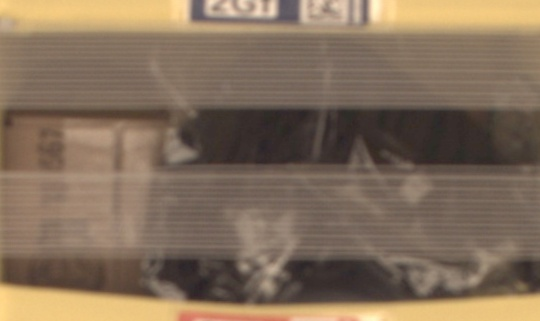

In [8]:
from PIL import Image

print("Image to be predicted")

b = Image.open("./image.jpg")

b

### Model Deploying and Querying

In [11]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
bucket = "bucketforhp"
prefix = "model/smdebugger-bindataset-2023-03-04-13-59-29-038/output"
model = PyTorchModel(
    entry_point="inference.py",
    source_dir="./",
    role=role,
    model_data='s3://{}/{}/model.tar.gz'.format(bucket, prefix),
    framework_version="1.8",
    py_version="py36",
)

predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

---------------!

In [12]:
# Runing a prediction on the endpoint
import boto3
import numpy as np
from PIL import Image
import json

sm = boto3.client('sagemaker-runtime')

# Load the image as a NumPy array
arr = np.array(Image.open("image.jpg"))

# arr1 = np.arange(0,40)

# # Create a dictionary containing the NumPy array
data = {'arr': arr.tolist()}

endpoint_name = "pytorch-inference-2023-03-04-15-17-58-370"


response = sm.invoke_endpoint(EndpointName=endpoint_name, 
                              Body=json.dumps(data),
                              ContentType='application/json')

response = response['Body'].read().decode('utf-8')
print(response)

{"body": {"prob": [0.3096030354499817, 0.19786523282527924, 0.1733504980802536, 0.17010582983493805, 0.1490754336118698], "indices": ["4", "3", "2", "5", "1"], "class": {"1": 0, "2": 1, "3": 2, "4": 3, "5": 4}}}


In [14]:
import json

result = json.loads(response)


name = []
pro = []
for i in range(len(result['body']['indices'])):
    for key, val in result['body']['class'].items():
        if result['body']['indices'][i] == key:
            name.append(key)
            break


print("Top 5 classes")
name

Top 5 classes


['4', '3', '2', '5', '1']

In [15]:
# Deleting Endpoint
predictor.delete_endpoint()

### Multi-Instance Training

In [24]:
multi_estimator = PyTorch(
    entry_point = "train.py",
    base_job_name = "smdebugger-bindataset",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.m5.xlarge",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path=model_output_location,
    ## Debugger parameters
    rules = debugger_rules,
    debugger_hook_config = hook_config,
    ## Profilling Rules
    profiler_config = profiler_config,
    profiler_rules = profilling_rules
)


In [25]:
multi_estimator.fit({"training": "s3://machinelearningcapstoneproject/"},wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-bindataset-2023-03-04-15-32-03-182
